In [30]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.interpolate import UnivariateSpline
from scipy.stats import entropy
from scipy.fftpack import fft
from scipy.integrate import simps
from scipy.signal import find_peaks, peak_widths
# import peak prominence
from scipy.signal import peak_prominences
# use tsfresh to extract features
from tsfresh import extract_features
from tsfresh import select_features
from xgboost import XGBClassifier
import optuna
import tsfresh
from tqdm import tqdm

In [31]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



#### Projet de Détection de Menaces Radar
Bienvenue dans le Projet de Détection de Menaces Radar. Notre mission est claire : détecter les menaces potentielles pour garantir la sécurité de l'équipage et le succès de la mission. Nous disposons d'un système d'analyse spectrale avancé pour caractériser les signaux radar à une altitude de 10 km. Ces signaux, représentés par des Pulse Description Words (PDW), renferment des informations cruciales telles que la date de début, la durée, la puissance, les angles theta et phi, ainsi que la fréquence.

Imaginez notre vaisseau se déplaçant à une altitude constante de 10 km, à une vitesse de 1000 km/h vers le nord. La tâche qui nous incombe est de choisir et d'entraîner un algorithme d'apprentissage machine capable de détecter les menaces sur l'ensemble d'entraînement, puis d'évaluer ses performances sur l'ensemble de test.

Notre approche consistera à explorer les données, établir une référence de performance avec un algorithme simple, utiliser la bibliothèque scikit-learn pour entraîner des algorithmes de classification binaire, et enfin, évaluer les performances en termes d'accuracy ainsi que via les matrices de confusion.

### Lire les données

In [32]:
pdws = np.load('./radars/train/pdw-2.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['puissance']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']

<div class=consignes> et les fichiers d'annotations:</div>

In [33]:
with open('./radars/train_labels.json') as f:
    dict_labels_train = json.load(f)

with open('./radars/test_labels.json') as f:
    dict_labels_test = json.load(f)

In [34]:
## fonction qui lit les données et les regroupent dans une seul dataframe
def read_dataset(directory, type) :

    dataset=pd.DataFrame()
    labels=pd.DataFrame()
    for f in os.listdir(directory):
        if f.endswith('.npz') :
            num = ''.join(filter(lambda char: char.isdigit(), f))
            pdws = np.load(directory + f)
            data = [dataset, pd.DataFrame.from_dict({item: [pdws[item]] for item in pdws.files}, orient='index').T]
            dataset=pd.concat(data)
            if type == "train":
                label = 1 if dict_labels_train[f'pdw-{num}'] == "menace" else 0
            elif type == "test":
                label = 1 if dict_labels_test[f'pdw-{num}'] == "menace" else 0
            else:
                raise Exception("Type doit etre train ou test.")

            df_label = [labels, pd.DataFrame([label])]
            labels=pd.concat(df_label)
    dataset['label'] = labels
    return dataset


In [35]:
train_directory = './radars/train/'
test_directory = './radars/test/'

In [36]:
data_train=read_dataset(train_directory,"train")
data_test=read_dataset(test_directory,"test")
data_train.head()


,date,largeur,frequence,puissance,theta,phi,label
0,"[1.31, 24.985, 36.823, 66.42, 104.897, 122.655...","[0.291, 0.291, 0.293, 0.292, 0.291, 0.291, 0.2...","[2.2220113463017723, 2.1887378825919477, 2.204...","[-125.58248735699023, -133.03972100969634, -14...","[0.9578859532471261, 0.7757236420828455, 0.823...","[1.678935775441994, 1.8065992324090079, 1.3807...",0
0,"[3.72, 19.312, 24.814, 31.234, 40.408, 42.241,...","[0.138, 0.136, 0.138, 0.136, 0.138, 0.138, 0.1...","[3.011221070570557, 3.0262794017444095, 3.0064...","[-127.176799666022, -127.7514938922165, -127.2...","[2.7962717807754327, 3.100138202337863, 2.9741...","[1.5296932038533972, 1.7187292927487223, 1.709...",0
0,"[1.23, 2.4050000000000002, 4.947, 7.686, 8.077...","[0.045, 0.046, 0.047, 0.046, 0.047, 0.047, 0.0...","[0.5775149858095107, 0.6014989048175015, 0.603...","[-136.54763969095774, -137.30801750751016, -13...","[-0.7789643759979964, -0.7904830822552771, -0....","[1.7007768933263543, 1.4350204027988849, 1.616...",1
0,"[1.197, 5.844, 6.175, 6.509, 8.832, 14.141, 19...","[0.052000000000000005, 0.054, 0.054, 0.054, 0....","[2.615298332857083, 2.62242918292755, 2.624332...","[-137.02690249165343, -136.52336266438806, -13...","[2.282911293432099, 2.512693223576854, 2.29557...","[1.6295779562871548, 1.5292805747280926, 1.551...",0
0,"[1.948, 2.581, 8.918000000000001, 11.453, 14.6...","[0.1, 0.099, 0.101, 0.099, 0.101, 0.1, 0.101, ...","[2.094159598969494, 2.076497829864467, 2.09052...","[-152.35589252720055, -151.71615012940876, -15...","[2.303186855452594, 2.450106604528563, 2.13350...","[1.6909885379417153, 1.6725463133679173, 1.426...",0


In [121]:
np.diff(data_train.iloc[4,0])

array([0.633, 6.337, 2.535, ..., 1.901, 6.336, 1.901])

In [131]:
import pandas as pd
import numpy as np

# Assuming data_train is your DataFrame and 'date' is your column with lists of dates
def calculate_periods(date_list):
    if len(date_list) < 2:  # If there's less than 2 dates, we can't calculate a period
        return np.nan
    else:
        # Calculate differences between consecutive dates
        differences = np.diff(date_list)
        # Return the median of these differences as the "typical" period
        return min(differences)

# Apply this function to each row in your 'date' column
period= data_train['date'].apply(calculate_periods)






In [132]:
period

0    1.477
0    0.915
0    0.193
0    0.329
0    0.631
     ...  
0    0.165
0    0.284
0    1.736
0    1.743
0    0.394
Name: date, Length: 2000, dtype: float64

### Exploration des données

Le premier signal dans la dataframe du training contient (672,) impulsions.
Le deuxième signal dans la dataframe du training contient (1081,) impulsions.
le minimum du nombre d'impulsions par signal est de 458.
le maximum du nombre d'impulsions par signal est de 20014.
La moyenne du nombre d'impulsions par signal est de 1698.798.
Le premier quartile est de 692.75.
Le deuxième quartile est de 1013.5.
Le troisième quartile est de 1855.25.


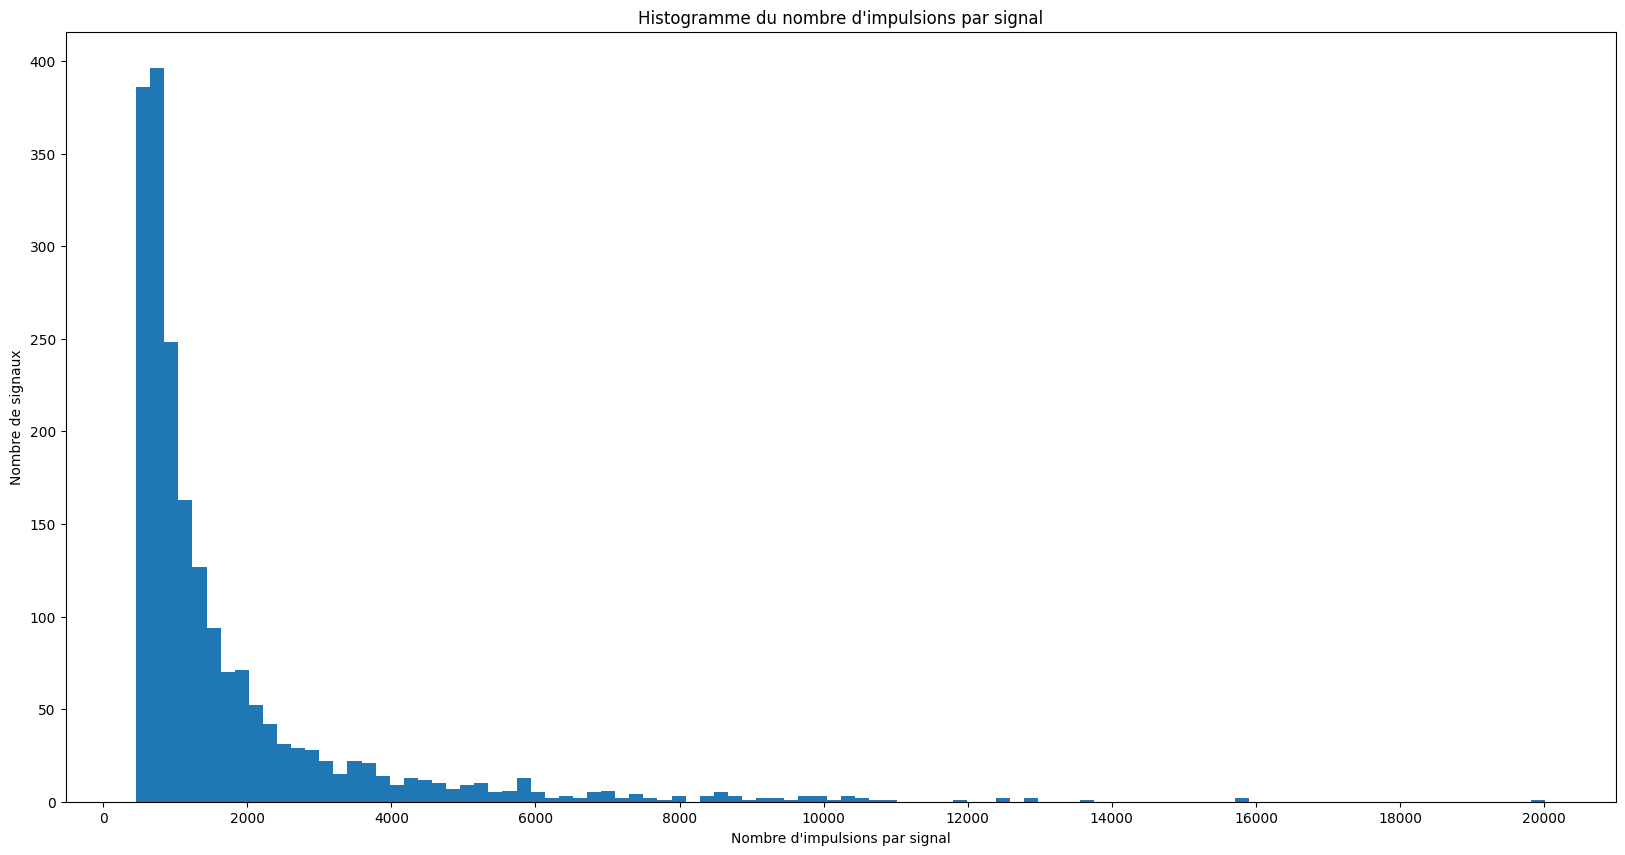

In [37]:
print(f"Le premier signal dans la dataframe du training contient {data_train.iat[0, 2].shape} impulsions.")
print(f"Le deuxième signal dans la dataframe du training contient {data_train.iat[1, 2].shape} impulsions.")
# calcule la moyenne du nombre d'impulsions par signal
impulsions = data_train["date"].apply(lambda x: len(x))
print(f"le minimum du nombre d'impulsions par signal est de {impulsions.min()}.")
print(f"le maximum du nombre d'impulsions par signal est de {impulsions.max()}.")
print(f"La moyenne du nombre d'impulsions par signal est de {impulsions.mean()}.")
# get quartile 1, 2 and 3
# make sure quartiles values are annotated on the boxplot
q1 = impulsions.quantile(0.25)
q2 = impulsions.quantile(0.5)
q3 = impulsions.quantile(0.75)
print(f"Le premier quartile est de {q1}.")
print(f"Le deuxième quartile est de {q2}.")
print(f"Le troisième quartile est de {q3}.")
# plot histogramme du nombre d'impulsions par signal
plt.figure(figsize=(20,10))
plt.hist(impulsions, bins=100)
plt.xticks(np.arange(0, 22000, 2000))
plt.xlabel("Nombre d'impulsions par signal")
plt.ylabel("Nombre de signaux")
plt.title("Histogramme du nombre d'impulsions par signal")
plt.show()

In [38]:
data_train.head(10)

,date,largeur,frequence,puissance,theta,phi,label
0,"[1.31, 24.985, 36.823, 66.42, 104.897, 122.655...","[0.291, 0.291, 0.293, 0.292, 0.291, 0.291, 0.2...","[2.2220113463017723, 2.1887378825919477, 2.204...","[-125.58248735699023, -133.03972100969634, -14...","[0.9578859532471261, 0.7757236420828455, 0.823...","[1.678935775441994, 1.8065992324090079, 1.3807...",0
0,"[3.72, 19.312, 24.814, 31.234, 40.408, 42.241,...","[0.138, 0.136, 0.138, 0.136, 0.138, 0.138, 0.1...","[3.011221070570557, 3.0262794017444095, 3.0064...","[-127.176799666022, -127.7514938922165, -127.2...","[2.7962717807754327, 3.100138202337863, 2.9741...","[1.5296932038533972, 1.7187292927487223, 1.709...",0
0,"[1.23, 2.4050000000000002, 4.947, 7.686, 8.077...","[0.045, 0.046, 0.047, 0.046, 0.047, 0.047, 0.0...","[0.5775149858095107, 0.6014989048175015, 0.603...","[-136.54763969095774, -137.30801750751016, -13...","[-0.7789643759979964, -0.7904830822552771, -0....","[1.7007768933263543, 1.4350204027988849, 1.616...",1
0,"[1.197, 5.844, 6.175, 6.509, 8.832, 14.141, 19...","[0.052000000000000005, 0.054, 0.054, 0.054, 0....","[2.615298332857083, 2.62242918292755, 2.624332...","[-137.02690249165343, -136.52336266438806, -13...","[2.282911293432099, 2.512693223576854, 2.29557...","[1.6295779562871548, 1.5292805747280926, 1.551...",0
0,"[1.948, 2.581, 8.918000000000001, 11.453, 14.6...","[0.1, 0.099, 0.101, 0.099, 0.101, 0.1, 0.101, ...","[2.094159598969494, 2.076497829864467, 2.09052...","[-152.35589252720055, -151.71615012940876, -15...","[2.303186855452594, 2.450106604528563, 2.13350...","[1.6909885379417153, 1.6725463133679173, 1.426...",0
0,"[18.664, 29.202, 35.687, 39.74, 41.36, 42.982,...","[0.155, 0.153, 0.153, 0.153, 0.153, 0.154, 0.1...","[1.8009761244934661, 1.8768636041544875, 1.963...","[-119.37407448982562, -122.05679574954785, -12...","[0.3180612804040588, 0.11656427707984456, -0.0...","[1.8511503890289778, 1.9211867172154178, 1.560...",1
0,"[5.644, 11.378, 24.278000000000002, 28.581, 77...","[0.097, 0.098, 0.098, 0.099, 0.097, 0.098, 0.0...","[1.6489709782665976, 1.6539755826301594, 1.646...","[-151.07892370194318, -148.53455765863416, -14...","[-2.007194616198999, -1.8076508204253678, -2.0...","[1.6147926719222183, 1.448127085537203, 1.5201...",0
0,"[5.938, 16.208000000000002, 19.801000000000002...","[0.054, 0.055, 0.055, 0.055, 0.054, 0.053, 0.0...","[1.2820341586150727, 1.2813653555877003, 1.273...","[-128.04497074532696, -128.63034038505575, -12...","[-2.5717787858885885, -2.56282040582604, -2.70...","[1.5666551426607562, 1.6266651602312865, 1.435...",1
0,"[1.026, 13.48, 23.861, 45.659, 47.734, 52.9250...","[0.109, 0.11, 0.109, 0.111, 0.11, 0.111, 0.11,...","[1.0288353699392658, 1.0326317717230202, 1.033...","[-133.62978914937318, -135.68938006771987, -13...","[1.2025741279386937, 1.1859128366809533, 1.375...","[1.6753534880235694, 1.734205984662301, 1.3268...",0
0,"[17.093, 41.844, 73.874, 81.153, 88.432, 98.62...","[0.27, 0.27, 0.27, 0.27, 0.271, 0.271, 0.269, ...","[2.8803307062666454, 2.8850796309210036, 2.896...","[-105.88437265658033, -104.06160350259664, -10...","[1.5404614915525547, 1.836297444868219, 2.1181...","[1.8497957853301044, 1.5539778670937778, 2.025...",0


Chaque instance de notres bases de données est un signal , qui contient différents impulsion , c'est à dire que les valeurs de nos features sont des listes de tailles différentes pour chaque instance , donc il est nécessaire de procéder avec des démarches de feature engineering pour pouvoir faire la classification

### Visualsation des statistiques d'un signal

In [39]:
# lets do some visualization for a signal with label 0 and another with label 1
data_train_0=data_train.iloc[0,]
data_train_1=data_train.iloc[5,]

In [40]:
# Group the DataFrame by 'Label' and calculate the mean feature length for each group
mean_feature_lengths = data_train.groupby('label')['date'].apply(lambda x: x.apply(len).mean())

# Display the mean feature length for each label
print(mean_feature_lengths)

label
0    1847.099901
1    1547.197169
Name: date, dtype: float64


In [41]:
data_train_0[:]

date         [1.31, 24.985, 36.823, 66.42, 104.897, 122.655...
largeur      [0.291, 0.291, 0.293, 0.292, 0.291, 0.291, 0.2...
frequence    [2.2220113463017723, 2.1887378825919477, 2.204...
puissance    [-125.58248735699023, -133.03972100969634, -14...
theta        [0.9578859532471261, 0.7757236420828455, 0.823...
phi          [1.678935775441994, 1.8065992324090079, 1.3807...
label                                                        0
Name: 0, dtype: object

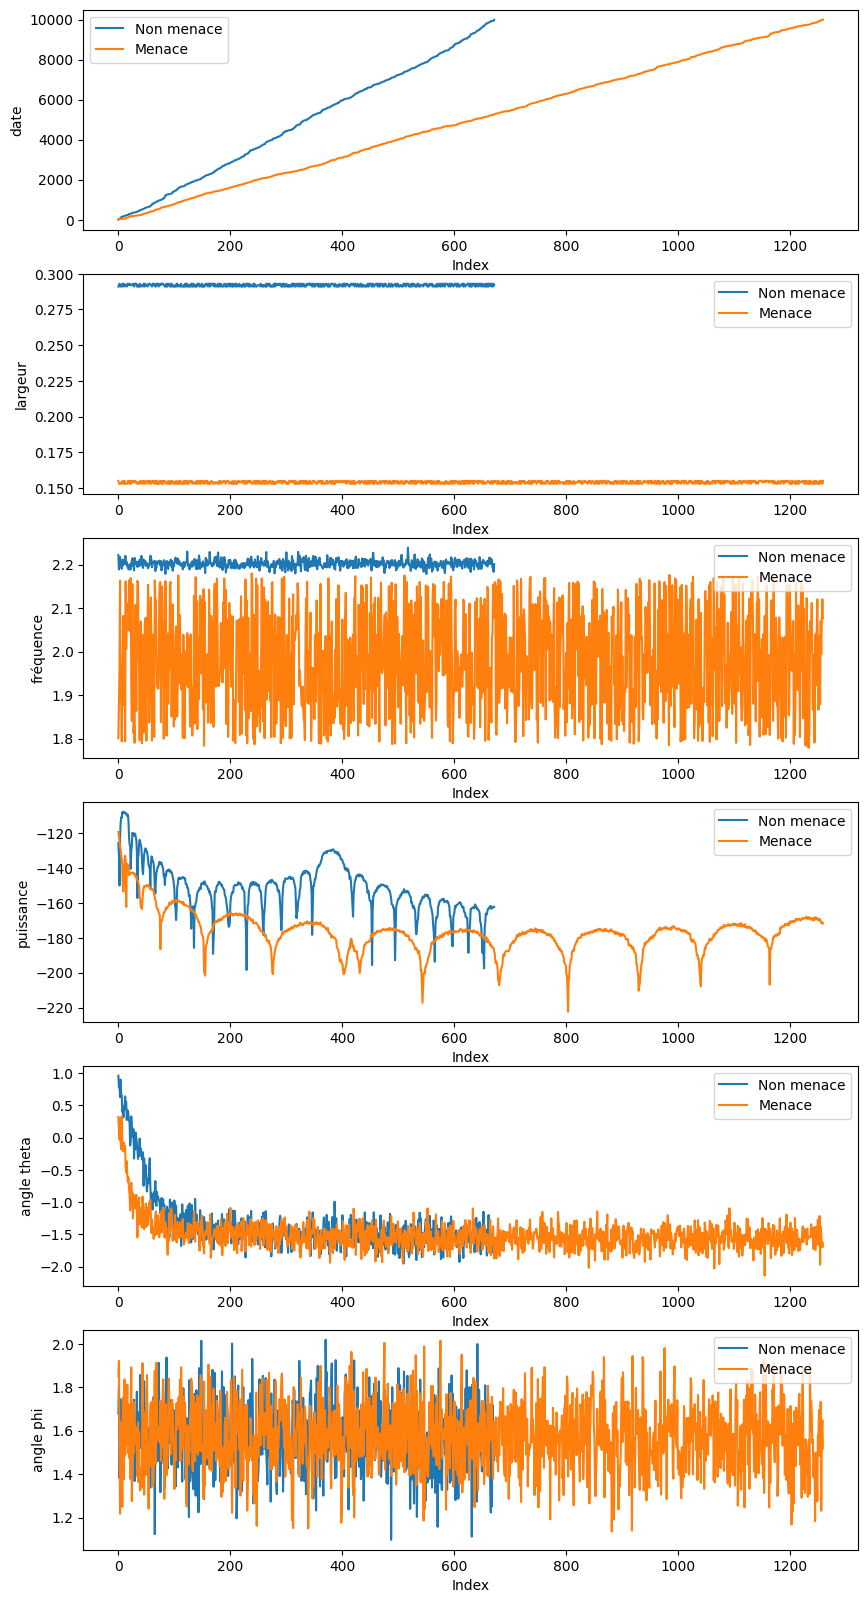

In [42]:

feature_names = ['date', 'largeur',  'fréquence', 'puissance', 'angle theta', 'angle phi']
# Supposons que vos caractéristiques soient stockées dans des listes
features_0 = data_train_0[:-1]  # Toutes les caractéristiques sauf le label pour l'instance 0
features_1 = data_train_1[:-1] # Toutes les caractéristiques sauf le label pour l'instance 1

# Créer une figure et des axes
fig, axs = plt.subplots(len(features_0), figsize=(10, 20))

# Pour chaque caractéristique
for i in range(len(features_0)):
    # Tracer la caractéristique pour l'instance 0
    axs[i].plot(features_0[i], label='Non menace')
    # Tracer la caractéristique pour l'instance 1
    axs[i].plot(features_1[i], label='Menace')
    # Ajouter une légende
    axs[i].legend()
    # Ajouter des étiquettes aux axes
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel(feature_names[i])

# Afficher la figure
plt.show()


one remarque des différences de distributions entre les instances de différentes labels , mais aussi entre les instances du meme label , donc je pense que c'est nécessaire de procéder à construire des features qui décrit les instances par leurs statistiques global , de plus vu les plots on pense que c'est mieux de remplacer la variable date par la variable diff_date qui donne la difference entre les deux détéctions de deux impulsions successives

### Visualizing des propriétés statistiques entre differents signaux

In [43]:
def count_peaks(signal):
    peaks, _ = find_peaks(signal)
    return len(peaks)

def zero_crossing_puissances(puissances):
  """
  Cette fonction rends le nombre de passage par zero de la dérivée de puissance
  puissances : les puissances des impulsions d'un signal.
  return : le nombre de passage par zero de la dérivée de puissance
  """
  derivee_puissance = np.gradient(puissances)
  x = np.arange(0, len(derivee_puissance), 1)
  spl = UnivariateSpline(x, derivee_puissance)
  return ((spl(x)[:-1] * spl(x)[1:]) < 0).sum()

def viz_stat(stat_function, df):

    function = lambda x: stat_function(x) if isinstance(x, np.ndarray) else x
    # Apply the mean function to all columns where 'label' is 0
    data_train_stat_0 = df[df['label'] == 0].apply(lambda x: x.apply(function))
    data_train_stat_1 = df[df['label'] == 1].apply(lambda x: x.apply(function))
    data_train_stat_0 = data_train_stat_0.reset_index(drop=True)
    data_train_stat_1 = data_train_stat_1.reset_index(drop=True)
    # drop the label column
    data_train_stat_0 = data_train_stat_0.drop(columns=['label'])
    data_train_stat_1 = data_train_stat_1.drop(columns=['label'])
    return data_train_stat_0, data_train_stat_1

set = "train"
dataset = data_train.iloc[:100, :] # on regarde les 100 premiers signaux
data_mean_0, data_mean_1 = viz_stat(np.mean, dataset)
data_var_0, data_var_1 = viz_stat(np.var, dataset)
data_min_0, data_min_1 = viz_stat(np.min, dataset)
data_max_0, data_max_1 = viz_stat(np.max, dataset)
data_crossings_0, data_crossings_1 = viz_stat(zero_crossing_puissances, dataset)



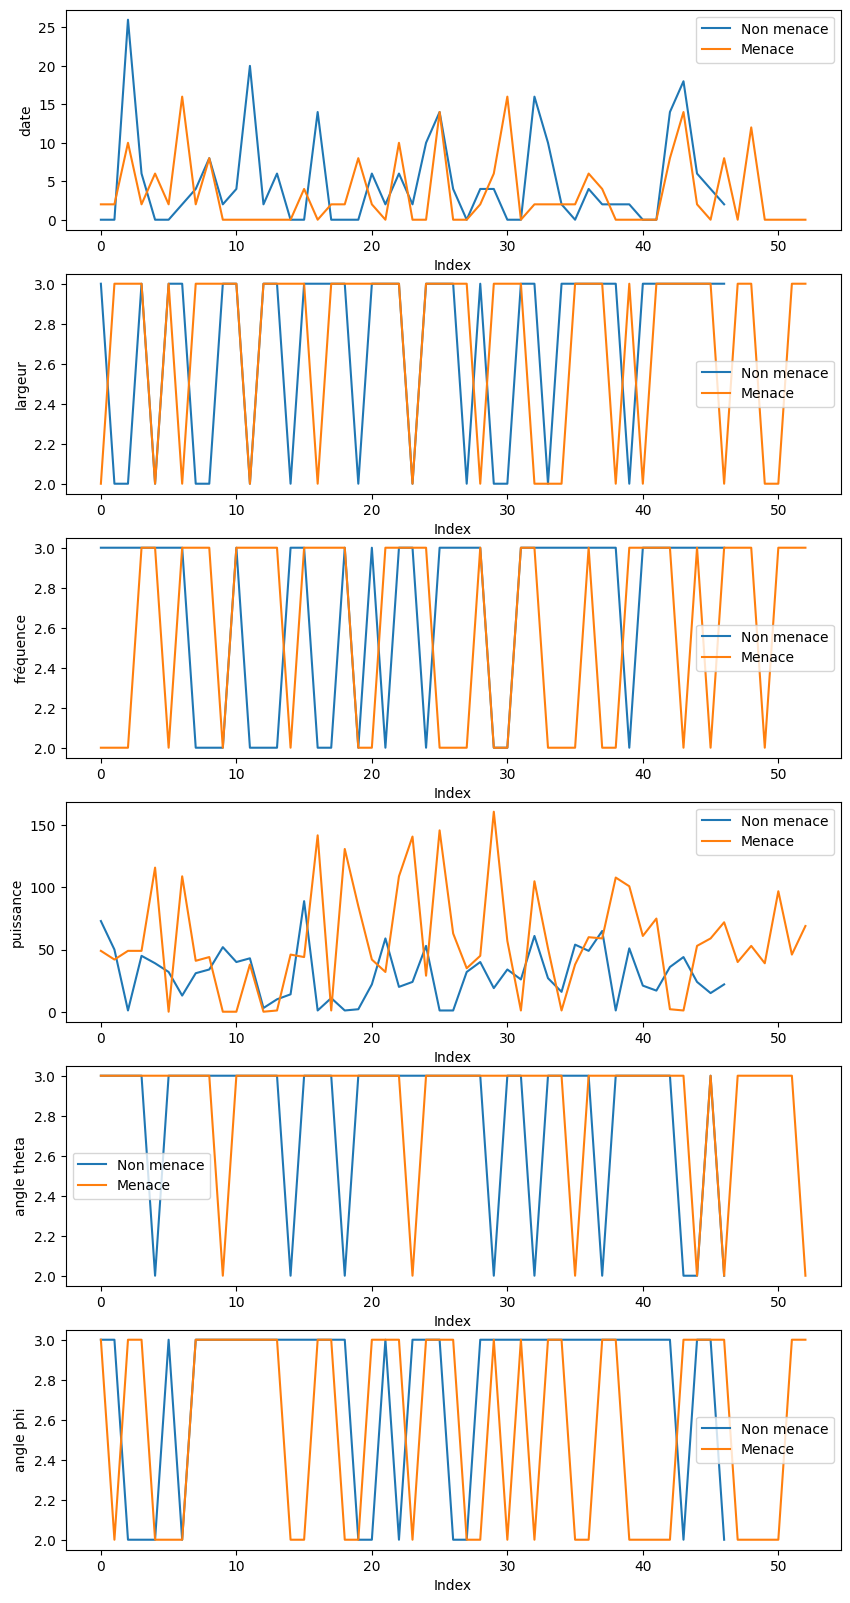

In [44]:
# Créer une figure et des axes
feature_names = ['date', 'largeur',  'fréquence', 'puissance', 'angle theta', 'angle phi', 'impulsions']
fig, axs = plt.subplots(data_mean_0.shape[1], figsize=(10, 20))
stat = "crossing"
n,m = data_mean_0.shape[0], data_mean_1.shape[0]
# Pour chaque caractéristique
for i in range(data_mean_0.shape[1]):
    if stat == "moyenne":
        axs[i].plot(data_mean_0.iloc[:,i], label='Non menace')
        axs[i].plot(data_mean_1.iloc[:,i], label='Menace')
    elif stat == "variance":
        axs[i].plot(data_var_0.iloc[:,i], label='Non menace')
        axs[i].plot(data_var_1.iloc[:,i], label='Menace')
    elif stat == "minimum":
        axs[i].plot(data_min_0.iloc[:,i], label='Non menace')
        axs[i].plot(data_min_1.iloc[:,i], label='Menace')
    elif stat == "maximum":
        axs[i].plot(data_max_0.iloc[:,i], label='Non menace')
        axs[i].plot(data_max_1.iloc[:,i], label='Menace')
    elif stat == "crossing" :
        axs[i].plot(data_crossings_0.iloc[:,i], label='Non menace')
        axs[i].plot(data_crossings_1.iloc[:,i], label='Menace')

    # Ajouter une légende
    axs[i].legend()
    # Ajouter des étiquettes aux axes
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel(feature_names[i])



### Les statistiques calculées à la main pour chaque feature(feature engineering) :
**frequence** : variance, minimum, maximum, entropie, largeur des peaks\
**puissance** : moyenne, minimum, moyenne, variance, entropie, largeur des peaks\
**date** : longueur des impulsions




In [133]:
def create_features(df) :
    new_df = pd.DataFrame()
    new_df['impulsions'] = df['date'].apply(lambda x: len(x))

    new_df['frequence_max'] = df['frequence'].apply(lambda x: np.max(x))
    new_df['frequence_min'] = df['frequence'].apply(lambda x: np.min(x))
    new_df['frequence_moyenne'] = df['frequence'].apply(lambda x: np.mean(x))
    new_df['frequence_variance'] = df['frequence'].apply(lambda x: np.var(x))
    new_df['frequence_entropy'] = df['frequence'].apply(lambda x: entropy(x))

    new_df['puissance_min'] = df['puissance'].apply(lambda x: np.min(x))
    new_df['puissance_max'] = df['puissance'].apply(lambda x: np.max(x))
    new_df['puissance_moyenne'] = df['puissance'].apply(lambda x: np.mean(x))
    new_df['puissance_variance'] = df['puissance'].apply(lambda x: np.var(x))
    new_df['puissance_entropy'] = df['puissance'].apply(lambda x: entropy(x))

    new_df["largeur_min"] = df["largeur"].apply(lambda x: np.min(x))
    new_df["largeur_max"] = df["largeur"].apply(lambda x: np.max(x))
    new_df["largeur_moyenne"] = df["largeur"].apply(lambda x: np.mean(x))
    new_df["largeur_variance"] = df["largeur"].apply(lambda x: np.var(x))
    new_df["largeur_entropy"] = df["largeur"].apply(lambda x: entropy(x))
    new_df["nombre_peak_puissance"]=df["puissance"].apply(zero_crossing_puissances)
    new_df["period"]=df['date'].apply(calculate_periods)



    # compute frequency fft to find frequency with max amplitude
    # new_df['frequency_fft'] = df['frequence'].apply(lambda x: np.argmax(np.abs(fft(x))))

    # get the mean difference between two occurences of maximum puissance
    # new_df['mean_diff_max_puissance'] = df['puissance'].apply(estimate_diff)


    # compute the mean peak prominence of the frequency signal
    new_df['puissance_mean_peak_prominence'] = df['puissance'].apply(lambda x: peak_prominences(x, find_peaks(x)[0])[0].mean())
    new_df['largeur_mean_peak_prominence'] = df['largeur'].apply(lambda x: peak_prominences(x, find_peaks(x)[0])[0].mean())
    new_df['theta_mean_peak_prominence'] = df['theta'].apply(lambda x: peak_prominences(x, find_peaks(x)[0])[0].mean())
    new_df['phi_mean_peak_prominence'] = df['phi'].apply(lambda x: peak_prominences(x, find_peaks(x)[0])[0].mean())

    # add the label column
    new_df['label'] = df['label']
    return new_df
train_features = create_features(data_train)
test_features = create_features(data_test)


In [134]:
# create X_train, y_train, X_test, y_test
X_train = train_features.iloc[:, :-1]
y_train = train_features.iloc[:, -1]
X_test = test_features.iloc[:, :-1]
y_test = test_features.iloc[:, -1]

In [135]:
# testing with best hyperparameters
n_estimators = 40
max_depth = 3
learning_rate = 0.4
clf = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average='macro')
print(f"Accuracy: {accuracy}")
print(f"f1 score: {f1}")

Accuracy: 0.88
f1 score: 0.8798919027124412


### Extraction des features sur les series temporelles en utilisant tsfresh

In [74]:
def df2features(df) :
    final_df = pd.DataFrame()
    for line_index in tqdm(range(len(df))):
        # Get the data for the selected line
        line_data = df.iloc[line_index]

        # Create a DataFrame with one column for each feature
        transformed_df = pd.DataFrame({
            'id' : line_index,
            'date': line_data['date'],
            'largeur': line_data['largeur'],
            'frequence': line_data['frequence'],
            'puissance': line_data['puissance'],
            'theta': line_data['theta'],
            'phi': line_data['phi'],
            'label' : line_data['label']
        })
        final_df = pd.concat([final_df, transformed_df])
    return final_df

train_df = df2features(data_train)
test_df = df2features(data_test)

100%|██████████| 800/800 [00:23<00:00, 33.83it/s] 


In [75]:
test_df.head()

,id,date,largeur,frequence,puissance,theta,phi,label
0,0,23.780,0.249,1.257851,-138.216440,0.025498,1.584248,1
1,0,28.952,0.250,1.261009,-127.015332,-0.171523,1.672516,1
2,0,35.162,0.249,1.262284,-123.506476,0.053188,1.444938,1
3,0,40.333,0.248,1.266049,-123.336834,-0.136761,1.714511,1
4,0,62.063,0.249,1.260704,-142.758003,-0.065256,1.823014,1


In [76]:
X_train = train_df.iloc[:, :-1]
# get y_train corresponding to unique ids
y_train = train_df.groupby('id').first()['label']

X_test = test_df.iloc[:, :-1]
y_test = test_df.groupby('id').first()['label']

In [77]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3397596, 7), (2000,), (1471224, 7), (800,))

In [78]:
fc_parameters = {
    "mean" : None,
    "variance" : None,
    "maximum" : None,
    "minimum" : None,
    "median" : None,
    "length" : None,
    "number_peaks" : [{"n" : 1}, {"n" : 3}, {"n" : 5}],
    "mean_second_derivative_central" : None,
    "mean_abs_change" : None,
    "sum_of_reoccurring_data_points" : None,
    "linear_trend" : [{"attr" : "intercept"}, {"attr" : "pvalue"}, {"attr" : "stderr"}],
    "abs_energy" : None,
    "ratio_value_number_to_time_series_length" : None,
}

In [79]:
X_train_features = extract_features(X_train, column_id='id', column_sort='date' , default_fc_parameters=fc_parameters)
X_test_features = extract_features(X_test, column_id='id', column_sort='date' , default_fc_parameters=fc_parameters)


Feature Extraction: 100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


In [85]:
X_train_features.shape

(2000, 85)

In [80]:
X_train_features.shape, X_test_features.shape, y_train.shape, y_test.shape

((2000, 85), (800, 85), (2000,), (800,))

In [81]:
X_train_features_filtered = select_features(X_train_features, y_train)
X_test_features_filtered = X_test_features[X_train_features_filtered.columns]

In [82]:
# testing with best hyperparameters grid search
n_estimators_grid = [10, 20, 30, 40, 50, 60, 70]
max_depth_grid = [5, 10]
learning_rate_grid = [0.1,0.7]
best_accuracy = 0
best_f1 = 0
best_n_estimators = 0
best_max_depth = 0
best_learning_rate = 0
for n_estimators in n_estimators_grid:
    for max_depth in max_depth_grid:
        for learning_rate in learning_rate_grid:
            clf = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
            clf.fit(X_train_features, y_train)
            predictions = clf.predict(X_test_features)
            accuracy = accuracy_score(y_test, predictions)
            f1 = f1_score(y_test, predictions, average='macro')
            print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, learning_rate: {learning_rate}, accuracy: {accuracy}, f1: {f1}")
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_f1 = f1
                best_n_estimators = n_estimators
                best_max_depth = max_depth
                best_learning_rate = learning_rate

n_estimators: 10, max_depth: 5, learning_rate: 0.1, accuracy: 0.89875, f1: 0.8978522167487685
n_estimators: 10, max_depth: 5, learning_rate: 0.7, accuracy: 0.8975, f1: 0.8973357371794872
n_estimators: 10, max_depth: 10, learning_rate: 0.1, accuracy: 0.89125, f1: 0.8908733425212961
n_estimators: 10, max_depth: 10, learning_rate: 0.7, accuracy: 0.8925, f1: 0.8923486152401816
n_estimators: 20, max_depth: 5, learning_rate: 0.1, accuracy: 0.90625, f1: 0.9058047804073943
n_estimators: 20, max_depth: 5, learning_rate: 0.7, accuracy: 0.90125, f1: 0.901038314770188
n_estimators: 20, max_depth: 10, learning_rate: 0.1, accuracy: 0.895, f1: 0.8946814112690888
n_estimators: 20, max_depth: 10, learning_rate: 0.7, accuracy: 0.89375, f1: 0.89354624085163
n_estimators: 30, max_depth: 5, learning_rate: 0.1, accuracy: 0.91, f1: 0.9097269239449334
n_estimators: 30, max_depth: 5, learning_rate: 0.7, accuracy: 0.8925, f1: 0.8923277243589743
n_estimators: 30, max_depth: 10, learning_rate: 0.1, accuracy: 0.89

In [95]:
n_estimators = 40
max_depth = 5
learning_rate = 0.1
clf = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
# trrain with all the features
clf.fit(X_train_features, y_train)
predictions = clf.predict(X_test_features)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average='macro')
print(f"Accuracy: {accuracy}")
print(f"f1 score: {f1}")
# train with the selected features
print("Training with features selected by tsfresh")
clf.fit(X_train_features_filtered, y_train)
predictions = clf.predict(X_test_features_filtered)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average='macro')
print(f"Accuracy: {accuracy}")
print(f"f1 score: {f1}")

Accuracy: 0.91125
f1 score: 0.9109426128622072
Training with features selected by tsfresh
Accuracy: 0.89875
f1 score: 0.898456634871684


In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def train_and_predict(X_train, X_test, y_train, y_test):
    # Initialize the model
    model = RandomForestClassifier()
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test data
    predictions = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy: {accuracy}')
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Keep only the top 10 most important features
    top_n = 10
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_names = [X_train.columns[i] for i in top_indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Top 10 Feature Importance")

    # Add bars
    plt.bar(range(top_n), top_importances)

    # Add feature names as x-axis labels
    plt.xticks(range(top_n), top_names, rotation=90)

    # Show plot
    plt.show()


Accuracy: 0.885


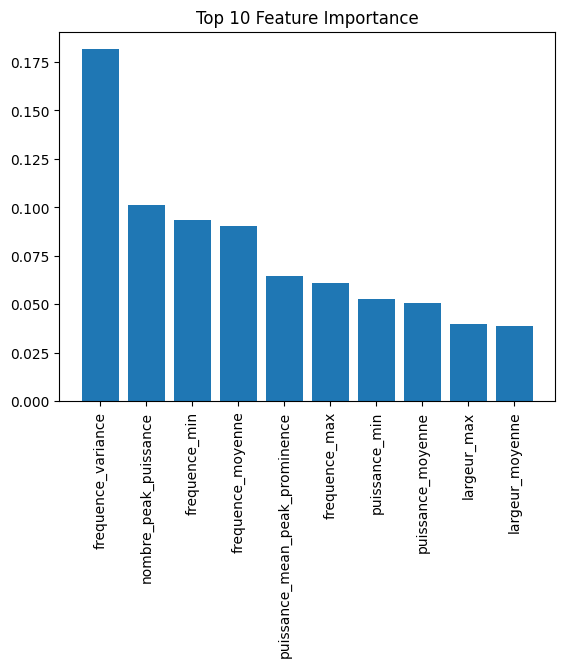

In [136]:
train_and_predict(X_train,X_test,y_train,y_test) 